<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Leonardo_Pacheco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = 'Leonardo Augusto da Silva Pacheco'

print(f'Meu nome é {nome}.')

Meu nome é Leonardo Augusto da Silva Pacheco.


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [4]:
batch_size = 50

## Download do CIFAR-10

In [5]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Criação do dataloader

In [6]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

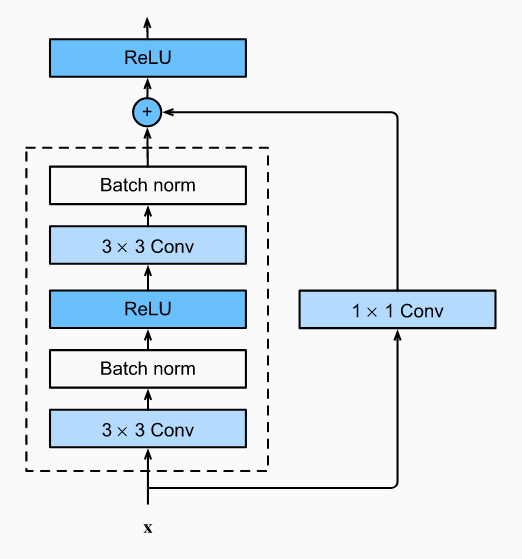

In [8]:
from torch import nn
from torch import Tensor
from torch.nn import Conv2d, BatchNorm2d, ReLU

class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        self.downsample = Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)
        self.conv1 = Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = BatchNorm2d(planes)
        self.conv2 = Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn2 = BatchNorm2d(planes)
        self.reLU = ReLU()
        
    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.reLU(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(x)
        out = self.reLU(out)
        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [9]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [11]:
from torch.nn import Linear, MaxPool2d

class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.basic1 = MyBasicBlock(inplanes=3, planes=32)
        self.basic2 = MyBasicBlock(inplanes=32, planes=64)
        self.flatten = nn.Flatten()
        self.dense = Linear(64 * 3 * 3, 10)
        self.pooling = nn.MaxPool2d(3,3)

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.basic1(x)
        out = self.pooling(out)
        out = self.basic2(out)
        out = self.pooling(out)
        out = self.flatten(out)
        #print('out', out.shape)
        logits = self.dense(out)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [12]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    model.eval()
    corrects = 0
    total = 0
    for x, y in tqdm(train_dataloader, total=len(train_dataloader), desc='Evaluating'):
      x = x.to(device)
      y = y.to(device)
      #print('x', x.shape, '     y', y.shape)
      y_pred = model(x).argmax(dim=1)
      #print('y_pred', y_pred.shape)
      corrects += (y == y_pred).sum().item()
      total += len(y)          
    mean_accuracy = corrects/total

    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [15]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Evaluating: 100%|██████████| 800/800 [00:09<00:00, 82.92it/s]


Accuracy: 0.126925


Training: 100%|██████████| 800/800 [00:13<00:00, 58.19it/s]


Epoch: 0/19 Loss: 0.9579715132713318


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 84.92it/s]


Accuracy: 0.6254


Training: 100%|██████████| 800/800 [00:13<00:00, 60.51it/s]


Epoch: 1/19 Loss: 0.8210280537605286


Evaluating: 100%|██████████| 800/800 [00:10<00:00, 73.35it/s]


Accuracy: 0.68845


Training: 100%|██████████| 800/800 [00:14<00:00, 53.95it/s]


Epoch: 2/19 Loss: 0.784546971321106


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 80.60it/s]


Accuracy: 0.73385


Training: 100%|██████████| 800/800 [00:13<00:00, 59.76it/s]


Epoch: 3/19 Loss: 0.6622940301895142


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 80.68it/s]


Accuracy: 0.767825


Training: 100%|██████████| 800/800 [00:14<00:00, 55.54it/s]


Epoch: 4/19 Loss: 0.8834015727043152


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 84.83it/s]


Accuracy: 0.787825


Training: 100%|██████████| 800/800 [00:13<00:00, 60.04it/s]


Epoch: 5/19 Loss: 0.6022968292236328


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 85.78it/s]


Accuracy: 0.804125


Training: 100%|██████████| 800/800 [00:13<00:00, 60.73it/s]


Epoch: 6/19 Loss: 0.4120749235153198


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 80.98it/s]


Accuracy: 0.81415


Training: 100%|██████████| 800/800 [00:13<00:00, 61.04it/s]


Epoch: 7/19 Loss: 0.6274834871292114


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 86.62it/s]


Accuracy: 0.838425


Training: 100%|██████████| 800/800 [00:13<00:00, 59.51it/s]


Epoch: 8/19 Loss: 0.4955787658691406


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 85.49it/s]


Accuracy: 0.85855


Training: 100%|██████████| 800/800 [00:13<00:00, 59.25it/s]


Epoch: 9/19 Loss: 0.5930039882659912


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 85.61it/s]


Accuracy: 0.846075


Training: 100%|██████████| 800/800 [00:13<00:00, 60.41it/s]


Epoch: 10/19 Loss: 0.38371437788009644


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 82.89it/s]


Accuracy: 0.843675


Training: 100%|██████████| 800/800 [00:13<00:00, 61.50it/s]


Epoch: 11/19 Loss: 0.4184989631175995


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 85.13it/s]


Accuracy: 0.865325


Training: 100%|██████████| 800/800 [00:13<00:00, 60.27it/s]


Epoch: 12/19 Loss: 0.31499138474464417


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 86.80it/s]


Accuracy: 0.894075


Training: 100%|██████████| 800/800 [00:13<00:00, 61.26it/s]


Epoch: 13/19 Loss: 0.3215489089488983


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 86.81it/s]


Accuracy: 0.903


Training: 100%|██████████| 800/800 [00:13<00:00, 61.31it/s]


Epoch: 14/19 Loss: 0.2563732862472534


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 86.40it/s]


Accuracy: 0.9021


Training: 100%|██████████| 800/800 [00:13<00:00, 61.41it/s]


Epoch: 15/19 Loss: 0.29156139492988586


Evaluating: 100%|██████████| 800/800 [00:08<00:00, 89.61it/s]


Accuracy: 0.8913


Training: 100%|██████████| 800/800 [00:12<00:00, 61.61it/s]


Epoch: 16/19 Loss: 0.39463165402412415


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 87.33it/s]


Accuracy: 0.91075


Training: 100%|██████████| 800/800 [00:12<00:00, 62.52it/s]


Epoch: 17/19 Loss: 0.4126007556915283


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 87.59it/s]


Accuracy: 0.9105


Training: 100%|██████████| 800/800 [00:13<00:00, 60.77it/s]


Epoch: 18/19 Loss: 0.28190839290618896


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 83.59it/s]


Accuracy: 0.9399


Training: 100%|██████████| 800/800 [00:13<00:00, 60.02it/s]


Epoch: 19/19 Loss: 0.22841453552246094


Evaluating: 100%|██████████| 800/800 [00:09<00:00, 84.66it/s]

Accuracy: 0.93


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

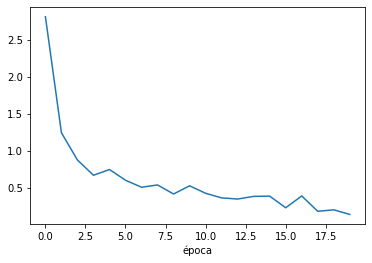

In [16]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [17]:
evaluation(model=model, loader=test_dataloader)

Evaluating: 100%|██████████| 800/800 [00:09<00:00, 87.11it/s]

Accuracy: 0.93


# Bonus Opcional

## Implementando o Dropout

In [112]:
from torch.nn import Module
class MyDropout(Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.
        if p <= 0.0 or p >= 1.0:
            raise ValueError("dropout probability has to be between 0 and 1, but got {}".format(p))
        self.p = p

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        if training:
            bias = torch.ones(x.shape) * p
            dropout = torch.rand(x.shape) > bias
            out = x * dropout
            #out /= (1 - self.p)
        else:
            out = x
        return out

    def __call__(self, x, training:bool):
      return self.forward(x, training)        

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [113]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.4972940981388092
mean zeros pytorch: 0.49688720703125
